<a href="https://colab.research.google.com/github/ibonetc/VisionAPI_TensorFlow_Python/blob/master/IA_DL_SeriesDeTiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning para series de tiempo

Los problemas de predicción con series de tiempo, según las variables pueden ser:

- Univariados: Una variable medida en el tiempo
- Multivariados: Varias variables medidas en el tiempo

Según la predicción:

- Un paso(One step): Si el problema requiere predicción del próximo paso de tiempo
- Multi-paso(Multi-step): Si se requiere predecir más de un paso en el tiempo.

Para mayor profundidad se puede ver el libro: Jason Brownlee, Deep Learning for Time Series Forecasting, 2019



## LSTM
Las redes recurrentes como Long Short-Term Memory (LSTM), a diferencia de un MLP o una red convolucional agregan el manejo explícito del orden entre observaciones al aprender una función de mapeo de entradas a salidas. En lugar de mapear entradas a salidas solo, la red es capaz de aprender una función de mapeo para las entradas a lo largo del tiempo hasta una salida.

### Preparación de los datos

Para redes convolucionales y LSTM los datos se series de tiempo deben tener una preparación previa para poder llevarlos a 3D

En las redes LSTM se debe especificar la entrada de los datos, los cuales tienen tres dimensiones que son:
- Ejemplos o casos: Cantidad de casos de la base
- Pasos de tiempo: Cantidad de puntos de observación en los ejemplos.
- Rasgos: Observaciones en el tiempo, o sea, acá los rasgos es la cantidad de variables en el tiempo que se tienen, en el caso de series de tiempo univariadas este valor es 1.

La serie se debe transformar de forma que se analice por ventanas

In [2]:
import numpy as np

In [3]:
# dividir una serie univariada en varios ejemplo a partir de un número de pasos
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [4]:
# Ejemplo de una serie univariada, un caso
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(series.shape)

(10,)


In [5]:
# transformar a un problema supervisado
X, y = split_sequence(series, 3)
print(X.shape, y.shape)
print('División de la serie:')
print([['   X  '],['y']])
[[x.tolist(),[yi]] for x,yi in zip(X,y)]

(7, 3) (7,)
División de la serie:
[['   X  '], ['y']]


[[[1, 2, 3], [4]],
 [[2, 3, 4], [5]],
 [[3, 4, 5], [6]],
 [[4, 5, 6], [7]],
 [[5, 6, 7], [8]],
 [[6, 7, 8], [9]],
 [[7, 8, 9], [10]]]

In [6]:
# transformar las entradas de [samples, features] a [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape)

(7, 3, 1)


Para el caso de LSTM se necesita procesar los ejemplos donde cada ejemplo es una simple secuencia, pero si la secuencia es muy grande (mayor que 400 pasos de tiempo) es mejor dividirla. Esta división puede hacerse con superposición o no.

Por ejemplo, en este caso tenemos una serie de 5000 pasos o puntos, y la dividimos en 25 subseries.

In [7]:
# Crear una serie de tiempo de 5000 puntos
data = list()
n = 5000
data=[[i+1, (i+1)*10] for i in range(n)]
data = np.array(data)
# eliminar la columna de tiempo
data = data[:, 1]
# dividir la serie en 25 subseries de tamaño 200 (5000/200 = 25)
samples = list()
length = 200
for i in range(0,n,length):
  sample = data[i:i+length]
  samples.append(sample)
print(len(samples))

25


In [8]:
print(data)
print(samples)

[   10    20    30 ... 49980 49990 50000]
[array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
       1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
       1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
       1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
       1

Para cambiar las dimensicones (reshape) de los datos:

In [9]:
len(samples)

25

In [13]:
# convertir lista de arreglos a un arreglo 2D
data = np.array(samples)
print(data.shape)

(25, 200)


In [14]:
# reshape a [samples, timesteps, features]
data = data.reshape((data.shape[0], data.shape[1], 1))
print(data.shape)

(25, 200, 1)


### Ejemplo usando LSTM con series univariadas

In [ ]:
# Preparación de los datos
# Suponiendo la siguiente serie
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# Seleccionando como paso de tiempo 3
n_steps = 3
# Dividiendo la serie
X, y = split_sequence(raw_seq, n_steps)
# Mostrando los datos
for i in range(len(X)):
  print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [ ]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X.shape)

(6, 3, 1)


#### Vanilla LSTM

Este es un modelo con una simple capa LSTM, y una capa de salida para la predicción.

A diferencia de una red CNN que lee a traves del vectro de entrada completo, LSTM lee un paso de tiempo cada vez y contruye una representanción interna que puede ser usada como un contexto aprendido para hacer una prediccion.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

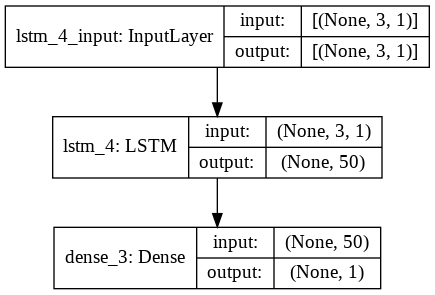

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 4460.2656
Epoch 2/500
1/1 [==============================] - 0s 10ms/step - loss: 4444.3877
Epoch 3/500
1/1 [==============================] - 0s 8ms/step - loss: 4428.0171
Epoch 4/500
1/1 [==============================] - 0s 8ms/step - loss: 4411.1313
Epoch 5/500
1/1 [==============================] - 0s 9ms/step - loss: 4393.6978
Epoch 6/500
1/1 [==============================] - 0s 9ms/step - loss: 4375.6650
Epoch 7/500
1/1 [==============================] - 0s 8ms/step - loss: 4356.9971
Epoch 8/500
1/1 [==============================] - 0s 8ms/step - loss: 4337.6538
Epoch 9/500
1/1 [==============================] - 0s 14ms/step - loss: 4317.5913
Epoch 10/500
1/1 [==============================] - 0s 8ms/step - loss: 4296.7646
Epoch 11/500
1/1 [==============================] - 0s 7ms/step - loss: 4275.1250
Epoch 12/500
1/1 [==============================] - 0s 7ms/step - loss: 4252.6167
Epoch 13/500
1/1 [======

Probando la predicción del modelo

In [ ]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.24589]]


#### Stacked LSTM

Es un modelo con múltiples capas LSTM.

Una capa LSTM requiere una entrada tridimensional y los LSTM de forma predeterminada producirán una salida bidimensional como una interpretación desde el final de la secuencia.
Para poder poner varias capas LSTM, podemos hacer que la capa LSTM genere un valor para cada paso de tiempo en los datos de entrada estableciendo las secuencias de retorno verdadero (*return_sequences=True*). Esto nos permite tener una salida 3D de la capa LSTM oculta como entrada a la siguiente. Por lo tanto, podemos definir un Satcked LSTM de la siguiente manera:

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps,n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

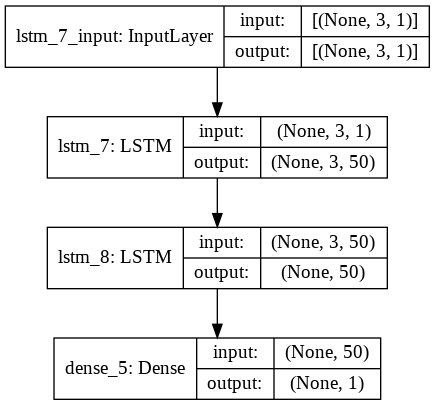

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 4625.4854
Epoch 2/500
1/1 [==============================] - 0s 9ms/step - loss: 4582.3804
Epoch 3/500
1/1 [==============================] - 0s 11ms/step - loss: 4542.5576
Epoch 4/500
1/1 [==============================] - 0s 11ms/step - loss: 4501.5220
Epoch 5/500
1/1 [==============================] - 0s 9ms/step - loss: 4464.6348
Epoch 6/500
1/1 [==============================] - 0s 9ms/step - loss: 4432.6489
Epoch 7/500
1/1 [==============================] - 0s 9ms/step - loss: 4403.6338
Epoch 8/500
1/1 [==============================] - 0s 19ms/step - loss: 4375.4932
Epoch 9/500
1/1 [==============================] - 0s 8ms/step - loss: 4347.8887
Epoch 10/500
1/1 [==============================] - 0s 16ms/step - loss: 4318.5229
Epoch 11/500
1/1 [==============================] - 0s 12ms/step - loss: 4286.4004
Epoch 12/500
1/1 [==============================] - 0s 10ms/step - loss: 4250.5747
Epoch 13/500
1/1 [==

In [ ]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.1372]]


#### Bidirectional LSTM

En algunos problemas de predicción de secuencia, puede ser beneficioso permitir que el modelo LSTM aprenda la secuencia de entrada tanto hacia adelante como hacia atrás y concatenar ambas interpretaciones. Esto se llama LSTM bidireccional. Podemos implementar un LSTM bidireccional para el pronóstico de series de tiempo univariante envolviendo la primera capa oculta en una capa de envoltura llamada Bidireccional.
Un ejemplo de definición de un LSTM bidireccional para leer la entrada tanto hacia adelante como hacia atrás es el siguiente.

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

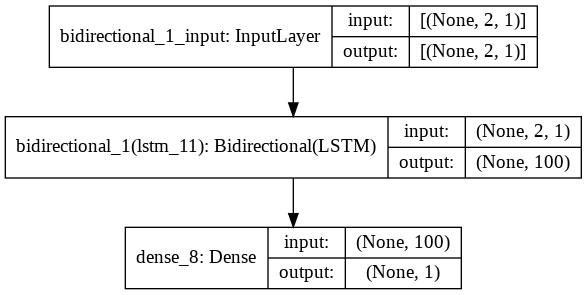

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 27s 27s/step - loss: 4109.4165
Epoch 2/500
1/1 [==============================] - 0s 11ms/step - loss: 4009.0996
Epoch 3/500
1/1 [==============================] - 0s 12ms/step - loss: 3910.1006
Epoch 4/500
1/1 [==============================] - 0s 12ms/step - loss: 3812.3132
Epoch 5/500
1/1 [==============================] - 0s 15ms/step - loss: 3715.5496
Epoch 6/500
1/1 [==============================] - 0s 9ms/step - loss: 3619.5791
Epoch 7/500
1/1 [==============================] - 0s 15ms/step - loss: 3524.0879
Epoch 8/500
1/1 [==============================] - 0s 9ms/step - loss: 3428.8210
Epoch 9/500
1/1 [==============================] - 0s 10ms/step - loss: 3333.5437
Epoch 10/500
1/1 [==============================] - 0s 17ms/step - loss: 3237.9260
Epoch 11/500
1/1 [==============================] - 0s 9ms/step - loss: 3142.2419
Epoch 12/500
1/1 [==============================] - 0s 11ms/step - loss: 3046.2996
Epoch 13/500
1/1

In [ ]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.36072]]


#### CNN-LSTM

Una red neuronal convolucional es un tipo de red neuronal desarrollada para trabajar con datos de imágenes bidimensionales, pero puede ser muy eficaz para extraer y aprender automáticamente características de datos de secuencia unidimensionales, como datos de series de tiempo univariantes. 

Un modelo CNN se puede usar en un modelo híbrido con una LSTM donde CNN se usa para interpretar subsecuencias de entrada que se proporcionan como una secuencia a un modelo LSTM para interpretar. Este modelo híbrido se llama CNN-LSTM.

Lo primero sería procesar la entrada para que pueda ser procesa por una CNN:
- Si por ejemplo, dividimos en 4 pasos las entradas, podemos hacer que la CNN lea esa entrada como un 2x2, o sea cada entrada de 4 puntos puede verse como dos subsecuencias de tamaño 2.

In [ ]:
# Procesar la entrada para ser interparada por un modelo CNN

In [ ]:
n_steps = 4
X, y = split_sequence(raw_seq, n_steps)
# reshape de [samples, timesteps] a [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
print(X.shape)

(5, 2, 2, 1)


In [ ]:
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D,Flatten,ConvLSTM2D,RepeatVector

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(64, 1, activation='relu'), input_shape=(None, n_steps,
n_features)))
model.add(TimeDistributed(MaxPooling1D()))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

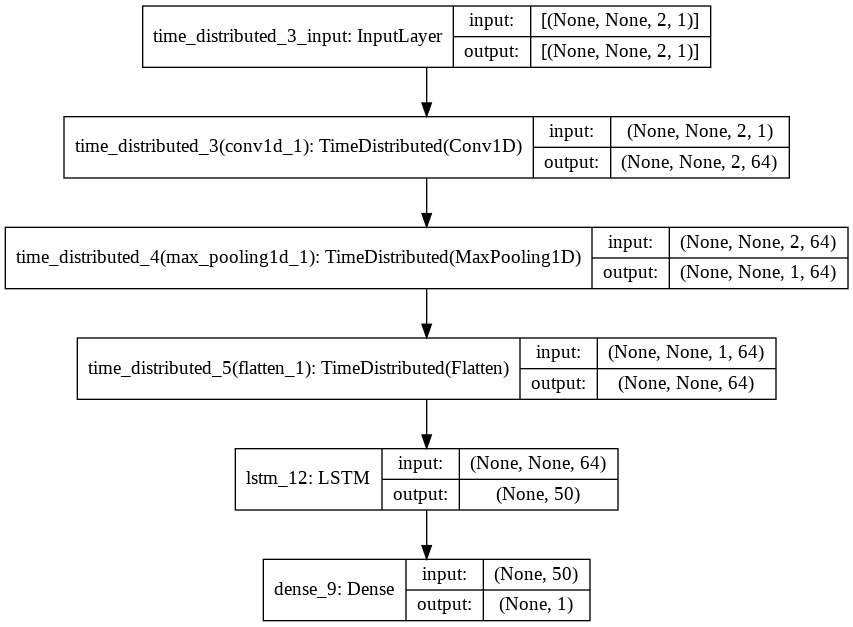

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 4196.9600
Epoch 2/500
1/1 [==============================] - 0s 12ms/step - loss: 4029.7585
Epoch 3/500
1/1 [==============================] - 0s 9ms/step - loss: 3856.4082
Epoch 4/500
1/1 [==============================] - 0s 11ms/step - loss: 3671.2397
Epoch 5/500
1/1 [==============================] - 0s 14ms/step - loss: 3477.0105
Epoch 6/500
1/1 [==============================] - 0s 23ms/step - loss: 3277.4407
Epoch 7/500
1/1 [==============================] - 0s 14ms/step - loss: 3072.9790
Epoch 8/500
1/1 [==============================] - 0s 12ms/step - loss: 2863.0823
Epoch 9/500
1/1 [==============================] - 0s 26ms/step - loss: 2649.2656
Epoch 10/500
1/1 [==============================] - 0s 23ms/step - loss: 2432.9246
Epoch 11/500
1/1 [==============================] - 0s 11ms/step - loss: 2211.7566
Epoch 12/500
1/1 [==============================] - 0s 10ms/step - loss: 1979.1375
Epoch 13/500
1/1

In [ ]:
x_input = np.array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.466385]]


#### ConvLSTM

Es un modelo relacionado con el anterior. Se desarrolló para leer datos espacio-temporales bidireccionales, pero se puede adaptar en predicciones de serie univariadas. La capa espara laentrada como una secuencia de imágenes bidireccionales, por lo que la forma de lo datos de entrada debe ser: [samples, timesteps, rows, columns, features].

Podemos dividir cada muestra en subsecuencias donde los pasos de tiempo se convertirán en el número de subsecuencias, o n seq, y las columnas serán el número de pasos de tiempo para cada subsecuencia, o n pasos.

El número de filas se fija en 1 ya que estamos trabajando con datos unidimensionales


In [ ]:
n_steps = 4
X, y = split_sequence(raw_seq, n_steps)
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

In [ ]:
X.shape

(5, 2, 1, 2, 1)

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(64, (1,2), activation='relu', input_shape=(n_seq, 1, n_steps,n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

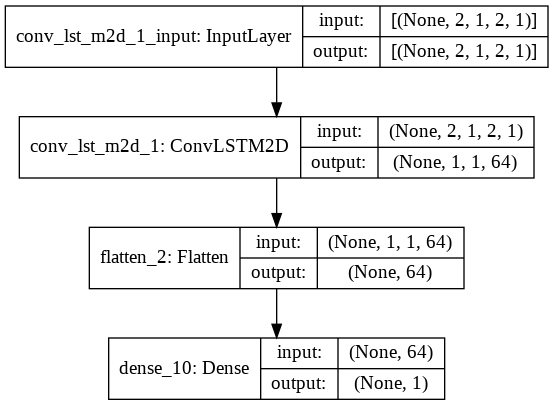

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 5623.4028
Epoch 2/500
1/1 [==============================] - 0s 18ms/step - loss: 5557.2969
Epoch 3/500
1/1 [==============================] - 0s 12ms/step - loss: 5492.6631
Epoch 4/500
1/1 [==============================] - 0s 11ms/step - loss: 5430.0225
Epoch 5/500
1/1 [==============================] - 0s 12ms/step - loss: 5369.9297
Epoch 6/500
1/1 [==============================] - 0s 11ms/step - loss: 5315.0049
Epoch 7/500
1/1 [==============================] - 0s 11ms/step - loss: 5261.1743
Epoch 8/500
1/1 [==============================] - 0s 13ms/step - loss: 5207.7769
Epoch 9/500
1/1 [==============================] - 0s 11ms/step - loss: 5155.0073
Epoch 10/500
1/1 [==============================] - 0s 16ms/step - loss: 5101.8677
Epoch 11/500
1/1 [==============================] - 0s 8ms/step - loss: 5046.8984
Epoch 12/500
1/1 [==============================] - 0s 20ms/step - loss: 4990.5811
Epoch 13/500
1/1

In [ ]:
x_input = np.array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[104.28516]]


#### Multivariate LSTM

En un problema multivariado tenemos múltiples series de tiempo paralelas de entrada, o sea varias series que son medidas en el mismo intervalo de tiempo.

Suponga el siguiente ejemplo:

In [ ]:
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convertir a [rows, columns]
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# apilar columnas
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [ ]:
print(out_seq)

[[ 25]
 [ 45]
 [ 65]
 [ 85]
 [105]
 [125]
 [145]
 [165]
 [185]]


In [ ]:
in_seq1

array([[10],
       [20],
       [30],
       [40],
       [50],
       [60],
       [70],
       [80],
       [90]])

In [ ]:
out_seq

array([[ 25],
       [ 45],
       [ 65],
       [ 85],
       [105],
       [125],
       [145],
       [165],
       [185]])

In [ ]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [ ]:
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps
    if end_ix > len(sequences):
      break
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

Vamos a tomar 3 tiempos de cada combinación de las series

In [ ]:
n_steps = 3
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
for i in range(len(X)):
  print(X[i], y[i])

(7, 3, 2) (7,)
[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185


In [ ]:
n_features = X.shape[2]

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 21971.1523
Epoch 2/500
1/1 [==============================] - 0s 14ms/step - loss: 21760.2656
Epoch 3/500
1/1 [==============================] - 0s 10ms/step - loss: 21540.0469
Epoch 4/500
1/1 [==============================] - 0s 12ms/step - loss: 21310.4668
Epoch 5/500
1/1 [==============================] - 0s 8ms/step - loss: 21068.3711
Epoch 6/500
1/1 [==============================] - 0s 13ms/step - loss: 20808.8691
Epoch 7/500
1/1 [==============================] - 0s 9ms/step - loss: 20524.1855
Epoch 8/500
1/1 [==============================] - 0s 10ms/step - loss: 20214.7520
Epoch 9/500
1/1 [==============================] - 0s 11ms/step - loss: 19882.5449
Epoch 10/500
1/1 [==============================] - 0s 13ms/step - loss: 19524.4375
Epoch 11/500
1/1 [==============================] - 0s 13ms/step - loss: 19137.8438
Epoch 12/500
1/1 [==============================] - 0s 16ms/step - loss: 18721.0371
Epoch

In [ ]:
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[205.51515]]


#### Multiples series paralelas con múltiples salidas

In [ ]:
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
in_seq3 = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
in_seq3

array([ 25,  45,  65,  85, 105, 125, 145, 165, 185])

In [ ]:
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps
    if end_ix > len(sequences)-1:
      break
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, in_seq3))

n_steps = 3
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

for i in range(len(X)):
  print(X[i], y[i])

(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]
[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]


Basado en este ejemplo donde estamos tomando 3 tiempo de la combinación de las tres series de entrada y debemos predecir tres salidas, una asociada a cada serie de entrada, que en este ejemplo estamos tratando de predecir el siguiente paso de tiempo para cada una, haremos el siguiente Stacked LSTM:

In [ ]:
n_features = X.shape[2]
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps,n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X, y, epochs=400)

Epoch 1/400
1/1 [==============================] - 4s 4s/step - loss: 9620.4619
Epoch 2/400
1/1 [==============================] - 0s 15ms/step - loss: 9427.6895
Epoch 3/400
1/1 [==============================] - 0s 20ms/step - loss: 9253.1885
Epoch 4/400
1/1 [==============================] - 0s 14ms/step - loss: 9066.4053
Epoch 5/400
1/1 [==============================] - 0s 18ms/step - loss: 8861.6055
Epoch 6/400
1/1 [==============================] - 0s 14ms/step - loss: 8643.1611
Epoch 7/400
1/1 [==============================] - 0s 19ms/step - loss: 8390.9424
Epoch 8/400
1/1 [==============================] - 0s 16ms/step - loss: 8102.7891
Epoch 9/400
1/1 [==============================] - 0s 17ms/step - loss: 7780.7114
Epoch 10/400
1/1 [==============================] - 0s 21ms/step - loss: 7431.4771
Epoch 11/400
1/1 [==============================] - 0s 18ms/step - loss: 7065.1328
Epoch 12/400
1/1 [==============================] - 0s 16ms/step - loss: 6679.5625
Epoch 13/400
1/

In [ ]:
x_input = np.array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input)
print(yhat)

[[100.53522 105.39363 205.80496]]


#### Modelo Autoencoder (Predicción de series de tiempo de múltiples pasos)

Este modelo está definido para cuando tenemos como entrada y como salida secuencias o señales, tales como traducción de texto de un lenguaje a otro, o para predicción de series de tiempo de múltiples pasos.

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
# ejemplo de entrada
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# seleccionar el número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2
# dividir la serie
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

In [ ]:
for i in range(len(X)):
  print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


In [ ]:
# reshape de [samples, timesteps] a [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

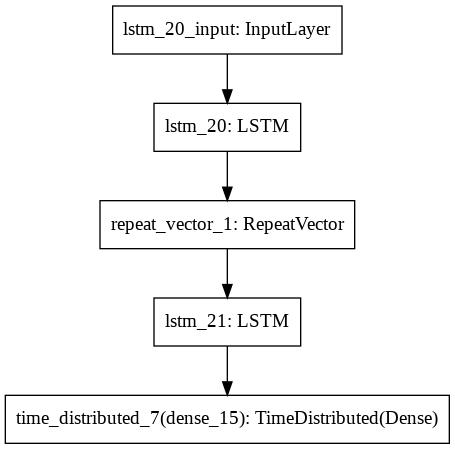

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.fit(X, y, epochs=100)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 4464.9238
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 4427.1953
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 4386.5703
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 4344.2656
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 4300.3799
Epoch 6/100
1/1 [==============================] - 0s 12ms/step - loss: 4252.5820
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 4197.3833
Epoch 8/100
1/1 [==============================] - 0s 16ms/step - loss: 4132.3647
Epoch 9/100
1/1 [==============================] - 0s 12ms/step - loss: 4055.5640
Epoch 10/100
1/1 [==============================] - 0s 21ms/step - loss: 3964.6379
Epoch 11/100
1/1 [==============================] - 0s 12ms/step - loss: 3856.5989
Epoch 12/100
1/1 [==============================] - 0s 12ms/step - loss: 3728.1089
Epoch 13/100
1/

In [ ]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[104.1454 ]
  [117.15274]]]


### Ejemplo1: Predecir venta de carro del próximo mes, a partir del histórico de varios meses.

Usaremos un ejemplo de ventas de carro en siguiente [csv](https://github.com/jbrownlee/Datasets/blob/d20fcb6402ae34e653d4513b00f39257bb37ed7f/monthly-car-sales.csv)

Las ventas están mensuales y se quiere predecir las ventas para el próximo mes.


Los datos se deben organizar como:

| X | Y |
| --- | --- |
|mes1, mes2, mes3, | mes4|
|mes2, mes3, mes4, | mes5|
|mes3, mes4, mes5, | mes6|
|...| ...|

In [ ]:
!wget 'https://github.com/jbrownlee/Datasets/blob/master/monthly-car-sales.csv'

--2021-07-30 17:22:35--  https://github.com/jbrownlee/Datasets/blob/master/monthly-car-sales.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘monthly-car-sales.csv’

monthly-car-sales.c     [ <=>                ] 137.53K  --.-KB/s    in 0.08s   

2021-07-30 17:22:36 (1.74 MB/s) - ‘monthly-car-sales.csv’ saved [140831]



In [ ]:
from math import sqrt
from numpy import array,mean,std
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#### Solución usando un MLP

In [ ]:
url='https://github.com/jbrownlee/Datasets/blob/d20fcb6402ae34e653d4513b00f39257bb37ed7f/monthly-car-sales.csv?raw=true'
serie = pd.read_csv(url, header=0,index_col=0)

In [ ]:
serie

,Sales
Month,
1960-01,6550
1960-02,8728
1960-03,12026
1960-04,14395
1960-05,14587
...,...
1968-08,16722
1968-09,14385
1968-10,21342


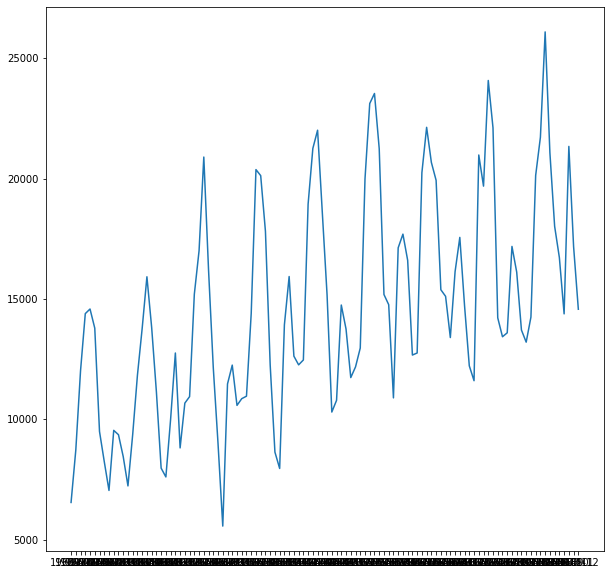

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(serie)
plt.show()

In [ ]:
data = serie.values

Dividiendo en entrenamiento y prueba (dejando los 12 últimos meses de prueba)

In [ ]:
n_test = 12
train, test=data[:-n_test], data[-n_test:]

Preparar los datos para un problema supervisado

In [ ]:
def series_to_supervised(data, n_in, n_out=1):
  df = pd.DataFrame(data)
  cols = list()
  # serie de entrada: (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # serie de predicción: (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # concatenar datos
  agg = pd.concat(cols, axis=1)
  # quitar valores vacíos
  agg.dropna(inplace=True)
  return agg.values

In [ ]:
n_input=24
train_data=series_to_supervised(train, n_input)

In [ ]:
train_data

array([[ 6550.,  8728., 12026., ..., 12759.,  8816., 10677.],
       [ 8728., 12026., 14395., ...,  8816., 10677., 10947.],
       [12026., 14395., 14587., ..., 10677., 10947., 15200.],
       ...,
       [17130., 17697., 16611., ..., 13434., 13598., 17187.],
       [17697., 16611., 12674., ..., 13598., 17187., 16119.],
       [16611., 12674., 12760., ..., 17187., 16119., 13713.]])

In [ ]:
train_x, train_y = train_data[:, :-1], train_data[:, -1]

In [ ]:
len(train_data[0])

25

In [ ]:
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.fit(train_x, train_y, epochs=100, batch_size=100)

Epoch 1/100
1/1 [==============================] - 0s 230ms/step - loss: 208708000.0000
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 82280824.0000
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 24784274.0000
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 25485984.0000
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 52212520.0000
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 69019480.0000
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 65682772.0000
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 49708208.0000
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 31472864.0000
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 18357700.0000
Epoch 11/100
1/1 [==============================] - 0s 4ms/step - loss: 13344319.0000
Epoch 12/100
1/1 [==============================] - 0s 4ms/s

Creando los datos para prueba, tomando desde los últimos datos del train para poder predecir el primero de test y corriendo un paso cada vez

In [ ]:
input_test = [x for x in train]
array(input_test[-n_input:]).reshape(1, n_input)

array([[12674, 12760, 20249, 22135, 20677, 19933, 15388, 15113, 13401,
        16135, 17562, 14720, 12225, 11608, 20985, 19692, 24081, 22114,
        14220, 13434, 13598, 17187, 16119, 13713]])

In [ ]:
input_test = [x for x in train]
predictions=[]
for i in range(len(test)):
  x_input = array(input_test[-n_input:]).reshape(1, n_input)
  yhat = model.predict(x_input, verbose=0)
  predictions.append(yhat[0])
  input_test.append(test[i])

In [ ]:
for t, p in zip(test, predictions):
  print(t, p, t-p)

[13210] [13201.193] [8.80664062]
[14251] [14960.514] [-709.51367188]
[20139] [19251.453] [887.546875]
[21725] [23309.72] [-1584.72070312]
[26099] [23473.258] [2625.7421875]
[21084] [22161.504] [-1077.50390625]
[18024] [17054.758] [969.2421875]
[16722] [14722.977] [1999.0234375]
[14385] [15815.21] [-1430.20996094]
[21342] [17618.71] [3723.2890625]
[17180] [18784.611] [-1604.61132812]
[14577] [15437.9795] [-860.97949219]


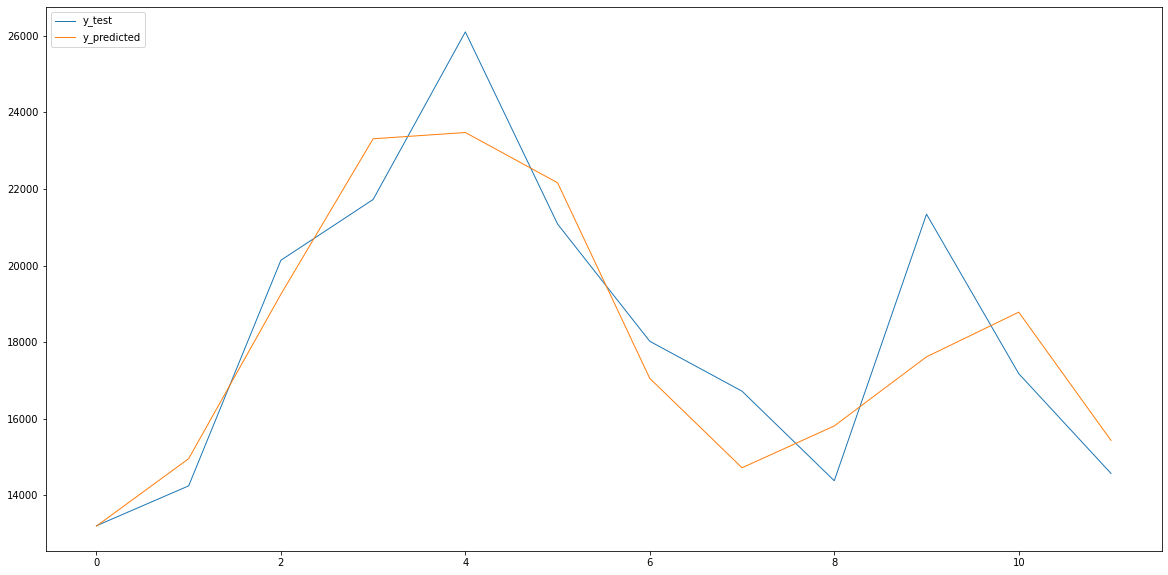

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(test, label='y_test',linewidth=1)
plt.plot(predictions, label='y_predicted',linewidth=1)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# estimar el error de predicción
error = sqrt(mean_squared_error(test, predictions))
print('%.3f RMSE' % error)

1732.486 RMSE


#### Solución usando un CNN

In [ ]:
n_test = 12
train, test=data[:-n_test], data[-n_test:]

In [ ]:
n_input, n_filters, n_kernel, n_epochs, n_batch=[36, 256, 3, 100, 100]

In [ ]:
train_data=series_to_supervised(train, n_input)
train_x, train_y = train_data[:, :-1], train_data[:, -1]

In [ ]:
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

In [ ]:
model = Sequential()
model.add(Conv1D(n_input, n_kernel, activation='relu', input_shape=(n_input, 1)))
model.add(Conv1D(n_input, n_kernel, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch)

Epoch 1/100
1/1 [==============================] - 0s 483ms/step - loss: 405731264.0000
Epoch 2/100
1/1 [==============================] - 0s 14ms/step - loss: 361456544.0000
Epoch 3/100
1/1 [==============================] - 0s 29ms/step - loss: 320451520.0000
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 282650976.0000
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 247821680.0000
Epoch 6/100
1/1 [==============================] - 0s 12ms/step - loss: 215586640.0000
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 185526528.0000
Epoch 8/100
1/1 [==============================] - 0s 12ms/step - loss: 157342512.0000
Epoch 9/100
1/1 [==============================] - 0s 12ms/step - loss: 130910776.0000
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 106504200.0000
Epoch 11/100
1/1 [==============================] - 0s 12ms/step - loss: 84138408.0000
Epoch 12/100
1/1 [=======================

In [ ]:
def model_predict(model, input_test, n_input):
  x_input = np.array(input_test[-n_input:]).reshape((1, n_input, 1))
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]

In [ ]:
input_test = [x for x in train]
predictions=[]
for i in range(len(test)):
  yhat =  model_predict(model, input_test, n_input)
  predictions.append(yhat)
  input_test.append(test[i])

error = sqrt(mean_squared_error(test, predictions))
print('%.3f RMSE' % error)

2564.701 RMSE


#### Solución usando LSTM

LSTM funciona mejor si los datos son estacionarios. Esto significa que se realizan operaciones de diferenciación para eliminar la estructura de tendencia y estacional. En el caso del conjunto de datos de ventas de automóviles, podemos hacer la estacionaliad de los datos realizando un ajuste estacional, es decir, restando el valor de hace un año de cada observación.
Esto significa que el primera año se descarta ya que no tenemos un año anterior.

In [ ]:
# Para la diferencia por año, n_diff=12
def difference(data, n_diff):
  return [data[i] - data[i - n_diff] for i in range(n_diff, len(data))]

In [ ]:
n_input, n_nodes, n_epochs, n_batch, n_diff = [12, 50, 100, 100, 12]

In [ ]:
if n_diff > 0:
  train = difference(train, n_diff)
data = series_to_supervised(train, n_input)
train_x, train_y = data[:, :-1], data[:, -1]
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch)

Epoch 1/100
1/1 [==============================] - 0s 48ms/step - loss: 1409764.2500
Epoch 2/100
1/1 [==============================] - 0s 38ms/step - loss: 1575590.8750
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 1826491.1250
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 2325059.5000
Epoch 5/100
1/1 [==============================] - 0s 54ms/step - loss: 1312766.8750
Epoch 6/100
1/1 [==============================] - 0s 43ms/step - loss: 1185740.5000
Epoch 7/100
1/1 [==============================] - 0s 46ms/step - loss: 1971552.0000
Epoch 8/100
1/1 [==============================] - 0s 45ms/step - loss: 1460702.5000
Epoch 9/100
1/1 [==============================] - 0s 57ms/step - loss: 1331514.3750
Epoch 10/100
1/1 [==============================] - 0s 51ms/step - loss: 1374294.6250
Epoch 11/100
1/1 [==============================] - 0s 52ms/step - loss: 1447230.3750
Epoch 12/100
1/1 [==============================] - 0s 50ms/ste

In [ ]:
def model_predict(model, history, n_input):
  # preparar datos
  correction = 0.0
  if n_diff > 0:
    correction = history[-n_diff]
    history = difference(history, n_diff)
  x_input = array(history[-n_input:]).reshape((1, n_input, 1))
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return correction + yhat[0]

In [ ]:
input_test = [x for x in train]
predictions=[]
for i in range(len(test)):
  x_input = array(input_test[-n_input:]).reshape((1, n_input, 1))
  yhat = model.predict(x_input, verbose=0)
  predictions.append(yhat[0])
  input_test.append(test[i])
error = sqrt(mean_squared_error(test, predictions))
print('%.3f RMSE' % error)

14354.612 RMSE


In [ ]:
input_test = [x for x in train]
predictions=[]
for i in range(len(test)):
  yhat =  model_predict(model, input_test, n_input)
  predictions.append(yhat)
  input_test.append(test[i])

error = sqrt(mean_squared_error(test, predictions))
print('%.3f RMSE' % error)

13221.385 RMSE


In [ ]:
predictions

[array([-724.3277], dtype=float32),
 array([2472.3357], dtype=float32),
 array([2539.505], dtype=float32),
 array([3717.0771], dtype=float32),
 array([5430.9233], dtype=float32),
 array([6015.6187], dtype=float32),
 array([5188.459], dtype=float32),
 array([4978.8853], dtype=float32),
 array([5011.456], dtype=float32),
 array([5330.085], dtype=float32),
 array([6456.2217], dtype=float32),
 array([5110.897], dtype=float32)]

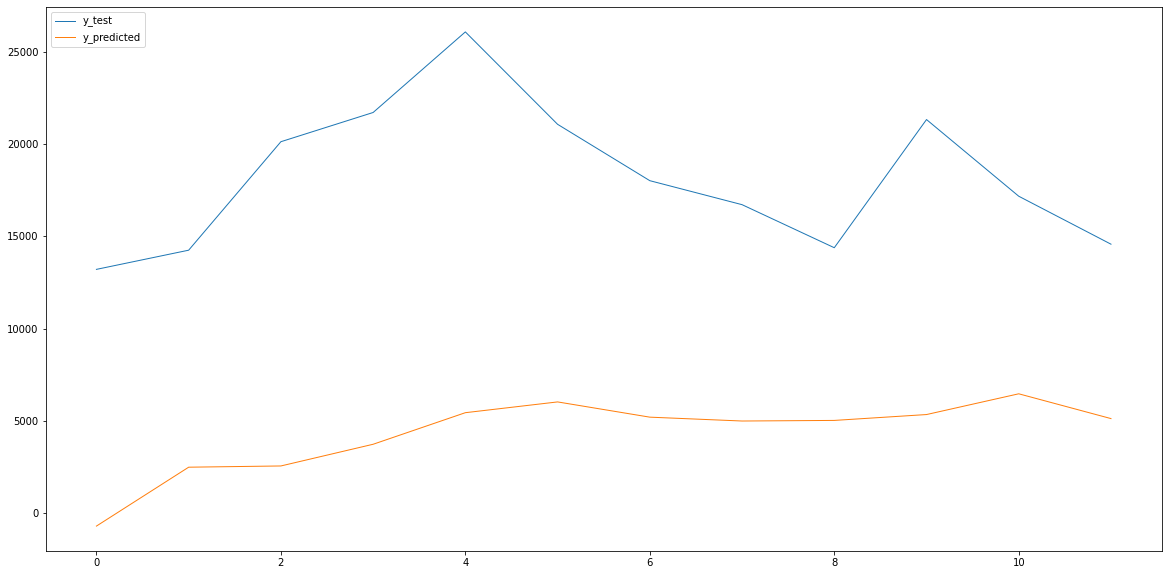

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(test, label='y_test',linewidth=1)
plt.plot(predictions, label='y_predicted',linewidth=1)
plt.legend(loc='upper left')
plt.show()

### Ejemplo: Datos meteorológicos (Ejemplo tomado de [keras](https://www.tensorflow.org/tutorials/structured_data/time_series))

Este conjunto de datos tiene 14 características diferentes, como la temperatura del aire, la presión atmosférica y la humedad. Estos se recopilaron cada 10 minutos, a partir de 2003. Para mayor eficiencia, utilizará solo los datos recopilados entre 2009 y 2016.

Vamos a hacer predicciones por hora


#### Cargar datos

In [ ]:
import os

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


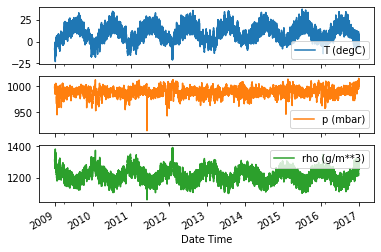

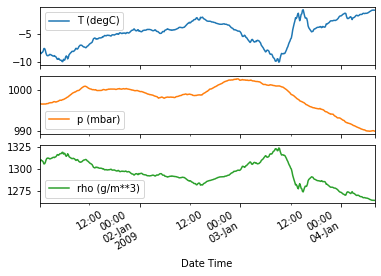

In [ ]:
date_time = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


#### Mostrar mapa de correlación

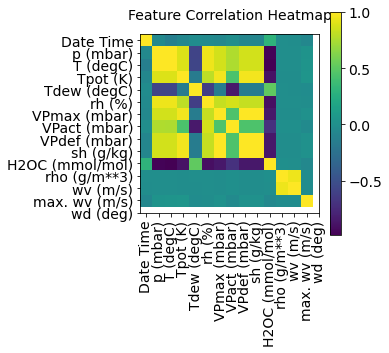

In [ ]:
def show_heatmap(data):
  plt.matshow(data.corr())
  plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
  plt.gca().xaxis.tick_bottom()
  plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=14)
  plt.title("Feature Correlation Heatmap", fontsize=14)
  plt.show()


show_heatmap(df)

#### Preprocesar los datos

In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

In [ ]:
def normalize(data, train_split):
  data_mean = data[:train_split].mean(axis=0)
  data_std = data[:train_split].std(axis=0)
  return (data - data_mean) / data_std

In [ ]:
feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

#### Entrenamiento de los datos

Vamos a seleccionar algunos parámetros

In [ ]:
print(
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [ ]:
date_time_key = "Date Time"
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [ ]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

La etiqueta de los datos comienza desde la observación 792

In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [ ]:
x_train

array([[ 0.95545114, -2.00002   , -1.31978162, ..., -1.50092673,
         2.23765845, -0.73299722],
       [ 0.96152792, -2.04518494, -1.33280552, ..., -1.51952063,
         2.28783773, -0.93600233],
       [ 0.9566665 , -2.0567657 , -1.3354103 , ..., -1.52323941,
         2.29860792, -1.28307559],
       ...,
       [-0.11163086,  0.90211719,  0.78097422, ...,  1.39228456,
        -0.92045437, -0.79193419],
       [-0.11770764,  0.89632681,  0.77185748, ...,  1.38856578,
        -0.91653794, -0.79193419],
       [-0.11041551,  0.8639007 ,  0.72757621, ...,  1.39600334,
        -0.88740948, -0.8312255 ]])

La siguiente función *timeseries_dataset_from_array* toma una secuencia de puntos de datos recopilados a intervalos iguales, junto con parámetros de series de tiempo como la longitud de las secuencias / ventanas, el espaciado entre dos secuencias / ventanas, etc., para producir lotes de entradas de subserie temporal y objetivos muestreados de las principales series temporales.

In [ ]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

#### Conjunto de validación

In [ ]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


In [ ]:
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=5,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/5
1172/1172 [==============================] - 70s 53ms/step - loss: 0.1862 - val_loss: 0.1491

Epoch 00001: val_loss improved from inf to 0.14910, saving model to model_checkpoint.h5
Epoch 2/5
1172/1172 [==============================] - 59s 50ms/step - loss: 0.1217 - val_loss: 0.1471

Epoch 00002: val_loss improved from 0.14910 to 0.14705, saving model to model_checkpoint.h5
Epoch 3/5
1172/1172 [==============================] - 59s 51ms/step - loss: 0.1126 - val_loss: 0.1540

Epoch 00003: val_loss did not improve from 0.14705
Epoch 4/5
1172/1172 [==============================] - 59s 50ms/step - loss: 0.1100 - val_loss: 0.1486

Epoch 00004: val_loss did not improve from 0.14705
Epoch 5/5
1172/1172 [==============================] - 58s 50ms/step - loss: 0.1080 - val_loss: 0.1498

Epoch 00005: val_loss did not improve from 0.14705


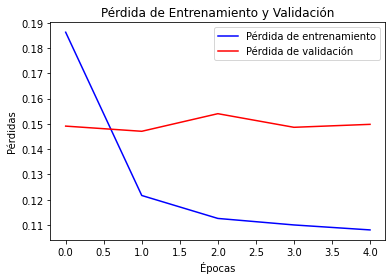

In [ ]:
def visualize_loss(history, title):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, "b", label="Pérdida de entrenamiento")
  plt.plot(epochs, val_loss, "r", label="Pérdida de validación")
  plt.title(title)
  plt.xlabel("Épocas")
  plt.ylabel('Pérdidas')
  plt.legend()
  plt.show()


visualize_loss(history, "Pérdida de Entrenamiento y Validación")

#### Predicción

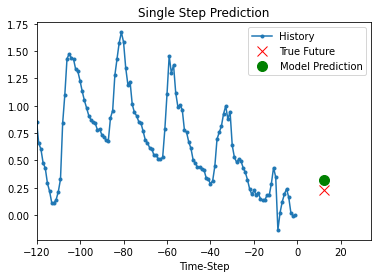

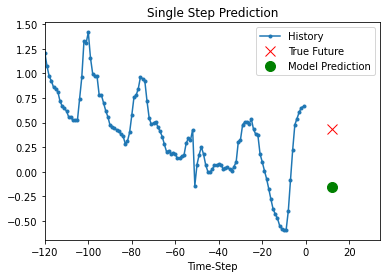

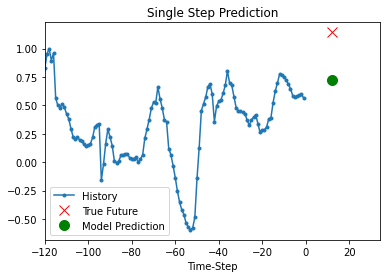

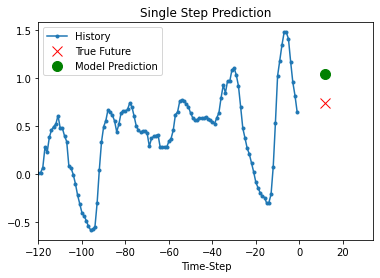

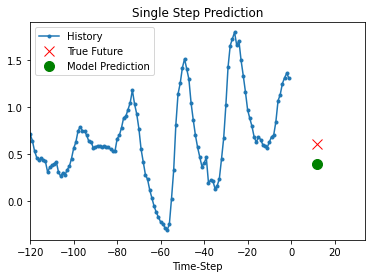

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

### Ejemplo: Clasificación de series de tiempo, reconocimiento usando Smartphones

Es el problema de predecir lo que está haciendo una persona basándose en un rastro de su movimiento mediante sensores.

Un conjunto de datos estándar de reconocimiento de actividad humana es el "Conjunto de datos de reconocimiento de actividad mediante teléfonos inteligentes", disponible en 2012.

Son datos de 30 sujetos de entre 19 y 48 años que realizaban una de las seis actividades estándar mientras usaban un teléfono inteligente montado en la cintura que registraba los datos de movimiento. Se grabó un video de cada sujeto realizando las actividades y los datos de movimiento se etiquetaron manualmente a partir de estos videos.

Las seis actividades realizadas fueron las siguientes:

- Caminando
- Subiendo escaleras
- Bajando escaleras
- Sentado
- De pie
- Acostado

Los datos de movimiento registrados fueron los datos del acelerómetro x, y, z (aceleración lineal) y los datos giroscópicos (velocidad angular) del teléfono inteligente, específicamente un Samsung Galaxy S II. Las observaciones se registraron a 50 Hz (es decir, 50 puntos de datos por segundo). Cada sujeto realizó la secuencia de actividades dos veces; una vez con el dispositivo en su lado izquierdo y una vez con el dispositivo en su lado derecho.

In [ ]:
!wget 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/HAR_Smartphones.zip'

--2021-07-31 00:36:55--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/HAR_Smartphones.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘HAR_Smartphones.zip.1’

HAR_Smartphones.zip 100%[===================>]  58.17M   109MB/s    in 0.5s    

2021-07-31 00:36:58 (109 MB/s) - ‘HAR_Smartphones.zip.1’ saved [60999314/60999314]



In [ ]:
!unzip '/content/HAR_Smartphones.zip'

Archive:  /content/HAR_Smartphones.zip
replace UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: UCI HAR Dataset/.DS_Store  
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt  
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_y_test.txt  
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_z_t

In [ ]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

#### Cargar los datos

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + '/content/UCI HAR Dataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + '/content/UCI HAR Dataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [ ]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


#### Crear modelo

In [ ]:
verbose, epochs, batch_size = 0, 15, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Entrenar
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

#### Evaluar el modelo

In [ ]:
# Evaluar
p, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

In [ ]:
accuracy=accuracy*100
accuracy

90.09161591529846

In [ ]:
predicted=model.predict(testX)

In [ ]:
testyy=np.argmax(testy,axis=1)
predictedy=np.argmax(predicted,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm=confusion_matrix(testyy,predictedy)
cm

array([[452,  17,  27,   0,   0,   0],
       [  8, 460,   1,   1,   1,   0],
       [  0,   2, 418,   0,   0,   0],
       [  1,   2,   0, 387, 101,   0],
       [  5,   3,   0, 103, 421,   0],
       [  0,  20,   0,   0,   0, 517]])

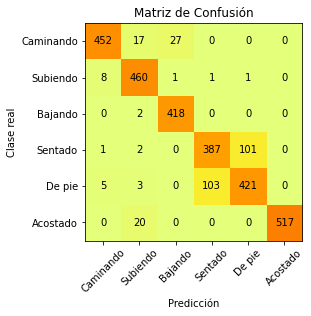

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Caminando','Subiendo','Bajando','Sentado','De pie','Acostado']
plt.title('Matriz de Confusión')
plt.ylabel('Clase real')
plt.xlabel('Predicción')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
#s = [['TN','FP'], ['FN', 'TP']]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i, str(cm[i][j]),ha="center", va="center")
        plt.rcParams["axes.grid"] = False
plt.show()

In [ ]:
def plot_cm(cm,classNames):
  plt.figure(figsize=(4,4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  plt.title('Matriz de Confusión')
  plt.ylabel('Clase real')
  plt.xlabel('Predicción')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  #s = [['TN','FP'], ['FN', 'TP']]
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          plt.text(j,i, str(cm[i][j]),ha="center", va="center")
          plt.rcParams["axes.grid"] = False
  plt.show()

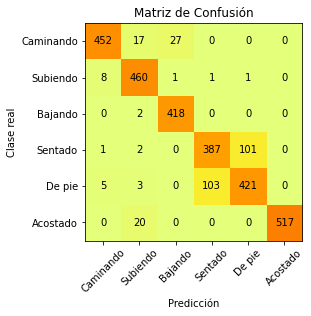

In [ ]:
classNames = ['Caminando','Subiendo','Bajando','Sentado','De pie','Acostado']
plot_cm(cm,classNames)

#### Modelo2: Salida con representación categórica

In [ ]:
trainyy=np.argmax(trainy,axis=1)
trainyy

array([4, 4, 4, ..., 1, 1, 1])

In [ ]:
testyy=np.argmax(testy,axis=1)
testyy

array([4, 4, 4, ..., 1, 1, 1])

In [ ]:
numclass=len(np.unique(testyy))
numclass

6

In [ ]:
n_timesteps, n_features= trainX.shape[1], trainX.shape[2]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(numclass, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(trainX, trainyy, epochs=epochs, batch_size=batch_size, verbose=verbose)

In [ ]:
_,accuracy=model.evaluate(testX, testyy, batch_size=batch_size, verbose=0)
accuracy*100

86.86800003051758

In [ ]:
predicted=model.predict(testX)

In [ ]:
ypredicted=np.argmax(predicted,axis=1)
ypredicted

array([4, 4, 4, ..., 1, 1, 1])

In [ ]:
cm=confusion_matrix(testyy,ypredicted)
cm

array([[450,  30,  16,   0,   0,   0],
       [  9, 447,  10,   3,   2,   0],
       [ 20, 103, 297,   0,   0,   0],
       [  0,   6,   0, 379, 105,   1],
       [  1,   0,   0,  81, 450,   0],
       [  0,   0,   0,   0,   0, 537]])

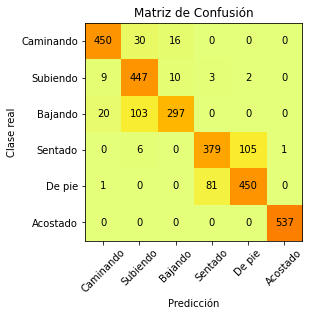

In [ ]:
classNames = ['Caminando','Subiendo','Bajando','Sentado','De pie','Acostado']
plot_cm(cm,classNames)